Remove archetype prediction redundancies among archetypes that overlap MPRA library. 

Use sliding window and median archetype length to select archetype w best score. 

annotate elements that do not overlap tile

In [2]:
import os, sys

sys.path.append(os.getcwd()) # append current working directory

import config_readwrite as crw  # custom script for reading config
import numpy as np
import pandas as pd
import pybedtools as pbt

import matplotlib.pyplot as plt
import seaborn as sns

import chr_functions

# config

In [6]:
config, cfn = crw.read("/wynton/home/ahituv/fongsl/biomarin/bin/config.neuron.mpra.orig.ini")

# read
section = "design"


LIB = "lib2"

if LIB == "lib1":
    TILES = config[section]["full_bed"]
    PATH = config[section]["PATH"]
    PREFIX = f"unq_tiles.{LIB}"
    VIERSTRA = os.path.join(PATH, f"{PREFIX}.x.vierstra.archetypes.bed")
    CLEANED = os.path.join(PATH, f"{PREFIX}.x.vierstra.archetypes.cleaned.bed")
    CLEANED_TABLE = os.path.join(PATH, f"{PREFIX}.x.vierstra.archetypes.cleaned.table.bed")


    section = "tfbs"
    crw.check(config, section)

    config[section]["vierstra"] = VIERSTRA  # write the tiles
    config[section]["vierstra.cleaned"] = CLEANED  # write the tiles
    config[section]["vierstra.cleaned.table"] = CLEANED_TABLE # max TFBS motif score, no redundancies within 13 bp. Not strand specific

else:
    
    TILES = "/wynton/group/ahituv/fongsl/projects/biomarin/library_2/design/biomarin-lib2-hg38-final.bed.gz"
    PATH = config[section]["path2"]
    PREFIX = "biomarin-lib2-hg38-final"
    VIERSTRA = os.path.join(PATH, f"{PREFIX}.x.vierstra.archetypes.bed.gz")
    VIERSTRA_MOTIF_LOC = os.path.join(PATH, f"{PREFIX}.x.vierstra.archetypes.motif.loc.bed.gz") # write
    VIERSTRA_MOTIF_LOC_NO_REDUNDANT = os.path.join(PATH, f"{PREFIX}.x.vierstra.archetypes.motif.loc.noredundant.bed.gz") # write
    LOSSES_AND_GAINS = '/wynton/group/ahituv/fongsl/projects/biomarin/results/TFBS_loss_gain.bed' # write


    section = "tfbs2"
    crw.check(config, section)

    config[section]["vierstra"] = VIERSTRA  # write the tiles
    config[section]["vierstra.motif.loc"] = VIERSTRA_MOTIF_LOC  # write the tiles
    config[section]["vierstra.motif.loc.nored"] = VIERSTRA_MOTIF_LOC_NO_REDUNDANT  # write the tiles
    config[section]["vierstra.motif.loc.nored.loss.gain"]= LOSSES_AND_GAINS # write the tiles with losses and gains only. 

crw.write(config, cfn)

In [7]:
ENH_BED = config["lib2"]["enh_bed"]

# run bedtools intersection

In [4]:
# intersect coordinates with bed tools using the -wao command. 
cmd = " ".join(["qsub", 
                "$HOME/vierstra_archetype.sh", 
                TILES
                ])
if os.path.exists(VIERSTRA) is False:
    os.system(cmd)
    
else:
    print("already intersected")

already intersected


# tiles 

In [ ]:
file_cols = list(pd.read_csv(VIERSTRA, sep='\t', nrows=1))

if "#chr" not in file_cols:
    if "motif_overlap" not in file_cols:
        # column names
        names = ["#chr", 'start_tile', "end_tile", "#chr_arch", "start_arch", "end_arch", "group",
            'arch', "strand", "model", "num_models", "overlap"]
    
        # load dataframe
        df = pd.read_csv(VIERSTRA, sep='\t', header=None, names=names, low_memory=False)
    
        # sort and save
        df.sort_values(by=list(df.columns[:3])).drop_duplicates().to_csv(VIERSTRA, sep='\t', index=False)
else:
    print('already rearranged columns, check if relative TF positions have been annotated')
    df = pd.read_csv(VIERSTRA, sep='\t', low_memory=False)

# label full overlap TF motifs

In [ ]:
tf = df.loc[df["overlap"] > 0].copy()

# compute motif length
tf["motif_len"] = tf["end_arch"] - tf["start_arch"]

# annotate fully overlapping motifs
tf["motif_overlap"] = False

# full overlap when tf motif len == overlap len
tf.loc[tf['motif_len'] == tf["overlap"],
        "motif_overlap"] = True

tf.groupby("motif_overlap")["#chr"].count()  #about 10% false overlaps

## sanity check - each group, model has one motif length 
(not multiple motif lengths for a model, group)

- check the length(s) of the motifs. If more than one motif length per motif, should print
  
              model [1, 2, etc.]
- If one motif length, print

              model [1]

In [ ]:
for col in ["model", "group"]:
    a = tf.groupby(col)["motif_len"].unique().reset_index()
    print(col,a["motif_len"].apply(lambda x: len(str(x).split(","))).unique()) # count the length of the unique motifs per model)
    
    print(len(set(tf[col])))

# add TFBS position

In [ ]:
"""Compute motif position relative to tile start"""

tf["start_motif"] = tf["start_arch"] -tf["start_tile"]
tf["end_motif"] = tf["end_arch"] -tf["start_tile"]
tf.head()

## filter motif score 
- keep only highly matching (score >=95% of scores per motif length) motifs
- remove motif scores where score <95% of length-matched scores.


In [ ]:
QUANTILE = 0.95


# change score datatype to float. Awkwardly, the match score column is named "arch". Nice job Sarah.
tf["arch"] = tf["arch"].astype(float)

# make a dictionary of 95% scores per motif lengh
thresh_dict = tf.groupby("motif_len")["arch"].quantile(
    QUANTILE).to_dict()  

### annotate motifs that exceed the 95% of motif match scores within length bin. 

In [ ]:
tf["thresh_score"] = False # make the column
tf["motif_len_thesh"] = tf["motif_len"].apply(lambda x: thresh_dict[x]) # add the threshold dictionary as a column
tf.loc[tf["arch"] > tf["motif_len_thesh"], "thresh_score"] = True  # compare whether archetype score meets the threshold score or not. 

### report number of motifs that exceed score thresholding

In [ ]:
print(tf.loc[tf["thresh_score"]==True].shape)

In [ ]:
# write motifs that exceed threshold. 
tf.loc[tf["thresh_score"]==True].to_csv(VIERSTRA_MOTIF_LOC, sep='\t', index=False, compression="gzip")

# Filter - remove redundant, multiple TF motif predictions at one prediction site
- remove TF predictions within +/- len of motif. 

In [3]:
TILE = config["lib2"]["tile_bed"]
tile = pd.read_csv(TILE, sep='\t')
tile.rename(columns={"start":"start_tile", "end":"end_tile"}, inplace=True)
tile.head()

,#chr,start_tile,end_tile,name
0,chr1,10057,10327,chr1:10057-10327
1,chr1,10077,10347,chr1:10077-10347
2,chr1,10097,10367,chr1:10097-10367
3,chr1,10117,10387,chr1:10117-10387
4,chr1,10133,10403,chr1:10133-10403


In [4]:
df = pd.read_csv(VIERSTRA_MOTIF_LOC, sep='\t')
df = pd.merge(df, tile, how="left").drop_duplicates()
df.head(400)

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,arch,strand,model,num_models,overlap,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,name
0,chr1,10117,10387,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,1,14,False,269,283,True,10.7289,chr1:10117-10387
1,chr1,10133,10403,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,253,267,True,10.7289,chr1:10133-10403
2,chr1,10137,10407,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,249,263,True,10.7289,chr1:10137-10407
3,chr1,10153,10423,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,233,247,True,10.7289,chr1:10153-10423
4,chr1,10157,10427,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,229,243,True,10.7289,chr1:10157-10427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,chr1,1693393,1693663,chr1,1693438,1693446,E2F/2,13.8285,+,E2F4_MOUSE.H11MO.0.A,9,8,8,True,45,53,True,10.7927,chr1:1693393-1693663
396,chr1,1693393,1693663,chr1,1693467,1693476,TFAP2/1,12.1831,-,AP2A_MOUSE.H11MO.0.A,32,9,9,True,74,83,True,10.8907,chr1:1693393-1693663
397,chr1,1693393,1693663,chr1,1693468,1693477,TFAP2/1,11.2848,+,Tcfap2a.mouse_TFAP_1,9,9,9,True,75,84,True,10.8907,chr1:1693393-1693663
398,chr1,1693393,1693663,chr1,1693478,1693488,NFY,13.3781,-,NFYB_HUMAN.H11MO.0.A,12,10,10,True,85,95,True,10.5357,chr1:1693393-1693663


In [5]:
def removeRedundantMotifArchs(df, tile_id, print=False):

    """ per tile, parse through motif matches.

        if two motifs are annotated within a distance < one motif length,
        if true, these are likely redundant matches.

        Keep the stronger motif match index, drop the other index.

        When motif match scores are equal, randomly choose one index to drop

        Return a vector of indexes with weaker motifs per tile that should be dropped
    """
    drop_indexes = []  # collect indexes that need to be dropped

    # subset tile dataframe
    tileid_df = df.loc[df["name"] == tile_id].sort_values(
       by=["group", "start_motif"]).drop_duplicates().copy()

    for group in tileid_df["group"].unique():
        
        # subset tile + group dataframe
        # consider one group at a time.
        test = tileid_df.loc[tileid_df["group"] == group].copy()

        # get motif length for the group.
        motif_len = test["motif_len"].iloc[0]

        # set variables for comparing and storing.
        last_start, last_score, last_index = 0, 0, 0

        if print is True:
            print(group, motif_len)
        
        for row in test.iterrows():  # parse through rows of one group.

            # get relative motif start, score and index inside one tile.
            start_motif, score, index = row[1]["start_motif"], row[1]["arch"], row[0]
            
            if last_start == 0:  # handle the first motif instance
                # set the start motif and score, as the last stored scores:
                last_start, last_score, last_index = start_motif, score, index
    
            else:  # compare between motifs
    
                # if the distance between the previous motif and current motif is less than the motif length
                if start_motif - last_start < motif_len:
                    if print is True:
                        print("too close", last_start, last_score, last_index, start_motif, score, index)
                        
                    if last_score > score:  # if the last match score is stronger than the current match score
                        drop_indexes.append(index)
                        # don't update last start, score, or index bc it was stronger than current motif
                    
                    elif score > last_score:
                        # or drop the last index bc match score was weaker
                        drop_indexes.append(last_index)
                        
                        # update the last start, score, and index
                        last_start, last_score, last_index = start_motif, score, index
                        
                    else:  # when scores are equal, randomly drop one
                        random_index=np.random.choice([index, last_index])
                        drop_indexes.append(random_index)

                        if random_index == last_index:
                            # update the last start, score, and index to the current index
                            last_start, last_score, last_index = start_motif, score, index
                else:  # no problems with too-close motif predictions, update
                    if print is True:
                        print("not too close", last_start, last_score, last_index, start_motif, score, index)
                    last_start, last_score, last_index = start_motif, score, index
            
        
    return drop_indexes, tileid_df

## example - GC-Tract is too close for many

In [6]:
# for one tile
TILEID = "chr19:54133850-54134120"
drop, tileiddf = removeRedundantMotifArchs(df, TILEID)

keep = tileiddf.loc[~tileiddf.index.isin(drop)].copy()

remove = tileiddf.loc[tileiddf.index.isin(drop)].copy()


cols = ["group", "motif_len", "arch", "start_motif"]
group = "GC-tract"

In [7]:
tileiddf.loc[tileiddf["group"]==group, cols] ## all tiles

,group,motif_len,arch,start_motif
172523,GC-tract,20,16.8620,-18
172526,GC-tract,20,13.8310,-13
172528,GC-tract,20,13.6118,-7
172530,GC-tract,20,14.0594,-5
172533,GC-tract,20,18.3199,-1
...,...,...,...,...
172707,GC-tract,20,14.5621,254
172708,GC-tract,20,14.6627,257
172711,GC-tract,20,16.8620,260
172714,GC-tract,20,16.9948,265


In [8]:
keep.loc[keep["group"] == group, cols]  # tiles to keep

,group,motif_len,arch,start_motif
172533,GC-tract,20,18.3199,-1
172550,GC-tract,20,17.1758,26
172558,GC-tract,20,16.9948,61
172579,GC-tract,20,18.7461,93
172609,GC-tract,20,20.1178,132
172646,GC-tract,20,19.6333,182
172678,GC-tract,20,19.3696,220
172701,GC-tract,20,18.3125,246
172716,GC-tract,20,14.0791,269


In [9]:
remove.loc[remove["group"] == group, cols]  # tiles to drop. 

,group,motif_len,arch,start_motif
172523,GC-tract,20,16.8620,-18
172526,GC-tract,20,13.8310,-13
172528,GC-tract,20,13.6118,-7
172530,GC-tract,20,14.0594,-5
172537,GC-tract,20,14.8538,3
...,...,...,...,...
172705,GC-tract,20,13.2279,252
172707,GC-tract,20,14.5621,254
172708,GC-tract,20,14.6627,257
172711,GC-tract,20,16.8620,260


## drop every too-close group prediction

In [10]:
drop_list = []
for tile_id in df["name"].unique():
    drop, tileiddf = removeRedundantMotifArchs(df, tile_id)
    drop_list.extend(drop)

In [11]:
drop_list[:3]

[92, 102, 105]

In [14]:
keep = df.loc[~df.index.isin(drop_list)].copy()
keep.shape, df.shape

((244439, 19), (327472, 19))

In [15]:
keep.head()

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,arch,strand,model,num_models,overlap,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,name
0,chr1,10117,10387,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,1,14,False,269,283,True,10.7289,chr1:10117-10387
1,chr1,10133,10403,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,253,267,True,10.7289,chr1:10133-10403
2,chr1,10137,10407,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,249,263,True,10.7289,chr1:10137-10407
3,chr1,10153,10423,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,233,247,True,10.7289,chr1:10153-10423
4,chr1,10157,10427,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,229,243,True,10.7289,chr1:10157-10427


In [18]:
keep.to_csv(VIERSTRA_MOTIF_LOC_NO_REDUNDANT, sep='\t', index=False, compression="gzip")

# Label motifs that are lost/gained

In [4]:
tf = pd.read_csv(VIERSTRA_MOTIF_LOC_NO_REDUNDANT, sep='\t')

tf.head()

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,arch,strand,model,num_models,overlap,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,name
0,chr1,10117,10387,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,1,14,False,269,283,True,10.7289,chr1:10117-10387
1,chr1,10133,10403,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,253,267,True,10.7289,chr1:10133-10403
2,chr1,10137,10407,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,249,263,True,10.7289,chr1:10137-10407
3,chr1,10153,10423,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,233,247,True,10.7289,chr1:10153-10423
4,chr1,10157,10427,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,3,14,14,True,229,243,True,10.7289,chr1:10157-10427


In [8]:
# add enhancer annotations
enh = pd.read_csv(ENH_BED, sep='\t')

df = pd.merge(tf, enh[["name", "tile.order", 'enh.name']], how="left")

df.head()

,#chr,start_tile,end_tile,#chr_arch,start_arch,end_arch,group,arch,strand,model,...,overlap,motif_len,motif_overlap,start_motif,end_motif,thresh_score,motif_len_thesh,name,tile.order,enh.name
0,chr1,10117,10387,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,...,1,14,False,269,283,True,10.7289,chr1:10117-10387,3.0,enh.0
1,chr1,10133,10403,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,...,14,14,True,253,267,True,10.7289,chr1:10133-10403,4.0,enh.0
2,chr1,10137,10407,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,...,14,14,True,249,263,True,10.7289,chr1:10137-10407,5.0,enh.0
3,chr1,10153,10423,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,...,14,14,True,233,247,True,10.7289,chr1:10153-10423,6.0,enh.0
4,chr1,10157,10427,chr1,10386,10400,NR/3,10.7457,-,COT1_HUMAN.H11MO.0.C,...,14,14,True,229,243,True,10.7289,chr1:10157-10427,7.0,enh.0


## add info about full loss/gain of TFBS as tiles shift across a locus

In [9]:
def varsToMakeNewRow(type, last_tile, tile, lasttile, currenttile):
    """return relevant info and direction to make new row"""
    if type =="gain":
    
        print("its a gain")
        update_tile = last_tile
        data = currenttile  # lasttile
        shift = 20
        other_name = lasttile["name"].iloc[0]
        motif_len = currenttile["motif_len"].iloc[0]
        
    elif type=="loss":
        print("its a loss")
    
        update_tile = tile
        data = lasttile
        shift = -20  # add 20 bases to start_tiles
        other_name = currenttile["name"].iloc[0]
        motif_len = lasttile["motif_len"].iloc[0] *-1

    return update_tile, data, shift, other_name, motif_len

In [10]:
def makeNewRowWOldInfo(model, data, update_tile, shift, other_name, motif_len, type):
    
    """cannibalize row with TF info, but change some info to match the tile this element is gained or lost in """
    new_row = data.loc[data["model"] == model].copy()
    new_row["overlap"] = 0
    new_row["motif_overlap"] = False
    new_row["tile.order"] = update_tile
    new_row['start_tile'], new_row['end_tile'] = new_row['start_tile'] - \
        shift, new_row['end_tile'] - shift

    # THIS IS INCORRECT. It isn't the shift that needs to be subtracted. It is the motif length that needs to be added or subtracted!!! Not improtant now, will fix later
    new_row['start_motif'], new_row['end_motif'] = new_row['start_motif'] + \
        motif_len, new_row['end_motif'] + motif_len
    new_row['name'] = other_name

    print("adding", model, type, "to", update_tile, "df")

    return new_row

In [11]:
newrows = {}
for enhid in df["enh.name"].unique():
    test = df.loc[df["enh.name"] == enhid].sort_values(by="start_tile")
    last_tile = 0
    for tile in test["tile.order"].unique():
        
        if tile !=0 and last_tile == tile-1: # check that this is not the first tile and that tiles are contiguous

            # get tile dataframes
            lasttile, currenttile = test.loc[test["tile.order"]
                                                 == last_tile], test.loc[test["tile.order"] == tile]

            # get sets of TF models in current and last tiles
            last_tfs, current_tfs = set(
                    lasttile["model"]), set(currenttile["model"])

            # increase last_tile counter to current tile
            last_tile = tile # up the tile

            # if TFs are not the same annotations between sets
            if last_tfs != current_tfs and lasttile.shape[0]>0 and currenttile.shape[0]>0:

                # find which tfs are lost (in last tile, but not current tile), or gained (in current tile, but not in last tile)
                lost, gained = list(last_tfs.difference(current_tfs)), list(
                        current_tfs.difference(last_tfs))
                print(tile, "lost in current", lost,
                          "'gained in current", gained)
                # add gained model info to last tile dataframe
                for model in gained:
                    type = "gain"
                    update_tile, data, shift, other_name, motif_len = varsToMakeNewRow(type, last_tile, tile, lasttile, currenttile)
                    new_row = makeNewRowWOldInfo(model, data, update_tile, shift, other_name, motif_len,  type)
                    newrows[f"{update_tile}.{model}"] = new_row
                
                # add lost model info to current tile dataframe        
                for model in lost:
                    type = "loss"
                    update_tile, data, shift, other_name, motif_len = varsToMakeNewRow(type, last_tile, tile, lasttile, currenttile)
                    new_row = makeNewRowWOldInfo(model, data, update_tile, shift, other_name, motif_len, type)
                    newrows[f"{update_tile}.{model}"] = new_row
                    
            lost, gained,  last_tfs, current_tfs = [], [], {}, {}
        else:
            last_tile=tile

12.0 lost in current [] 'gained in current ['MBD2_HUMAN.H11MO.0.B']
its a gain
adding MBD2_HUMAN.H11MO.0.B gain to 12.0 df
14.0 lost in current [] 'gained in current ['THA_HUMAN.H11MO.0.C']
its a gain
adding THA_HUMAN.H11MO.0.C gain to 14.0 df
17.0 lost in current [] 'gained in current ['HEN1_HUMAN.H11MO.0.C']
its a gain
adding HEN1_HUMAN.H11MO.0.C gain to 17.0 df
4.0 lost in current [] 'gained in current ['MAFK_bZIP_4']
its a gain
adding MAFK_bZIP_4 gain to 4.0 df
5.0 lost in current ['ZN554_HUMAN.H11MO.0.C'] 'gained in current []
its a loss
adding ZN554_HUMAN.H11MO.0.C loss to 5.0 df
1.0 lost in current ['GLIS2_C2H2_1', 'ZIC3_C2H2_1', 'SP3_HUMAN.H11MO.0.B'] 'gained in current ['AP2A_MOUSE.H11MO.0.A']
its a gain
adding AP2A_MOUSE.H11MO.0.A gain to 1.0 df
its a loss
adding GLIS2_C2H2_1 loss to 1.0 df
its a loss
adding ZIC3_C2H2_1 loss to 1.0 df
its a loss
adding SP3_HUMAN.H11MO.0.B loss to 1.0 df
2.0 lost in current [] 'gained in current ['NFYB_HUMAN.H11MO.0.A']
its a gain
adding NFYB_

In [186]:
losses_and_gains=pd.concat(newrows.values()).sort_values(by=["#chr", "start_tile"])

losses_and_gains.to_csv(LOSSES_AND_GAINS, sep='\t', index=False)

# cluster TF motifs and counts

In [160]:
tile_bed = enh[enh.columns[:3]].drop_duplicates().dropna()
tile_bed[tile_bed.columns[1:3]]=tile_bed[tile_bed.columns[1:3]].astype(int)
tile_bed.to_csv("/wynton/group/ahituv/fongsl/projects/biomarin/data/tileid.bed", sep='\t', index=False)

In [161]:
tile_bed

,#chr,start.tile,end.tile
0,chr1,10057,10327
1,chr1,10077,10347
2,chr1,10097,10367
3,chr1,10117,10387
4,chr1,10133,10403
...,...,...,...
44039,chrY,19745320,19745590
44040,chrY,19745340,19745610
44041,chrY,19745360,19745630
44042,chrY,19745380,19745650


In [162]:
enh_bed = enh[enh.columns[4:7]].drop_duplicates().dropna()
enh_bed[enh_bed.columns[1:3]]=enh_bed[enh_bed.columns[1:3]].astype(int)
enh_bed

,#chr.enh,start.enh,end.enh
0,chr1,10057,10563
18,chr1,1692002,1692432
27,chr1,1693180,1693663
45,chr1,2440188,2440764
72,chr1,2758163,2758751
...,...,...,...
43818,chrY,2935854,2936450
43845,chrY,12537123,12537553
43854,chrY,12661239,12663710
43963,chrY,12741976,12742567


In [163]:

enh_bed.to_csv("/wynton/group/ahituv/fongsl/projects/biomarin/data/enhid.bed", sep='\t', index=False)

In [139]:
tfs = df[["#chr", "start_arch", "end_arch", "group", "model", "enh.name"]].drop_duplicates().copy()
tfs.to_csv("/wynton/group/ahituv/fongsl/projects/biomarin/results/vierstra.arch.motif.non_redundant.bed", sep='\t', index=False)

In [65]:
tfs_grouped= tfs.groupby(['enh.name', "group"])["start_arch"].count().reset_index().sort_values(by="start_arch").copy()

In [66]:
table = pd.pivot(tfs_grouped, index="enh.name", columns = "group", values="start_arch")

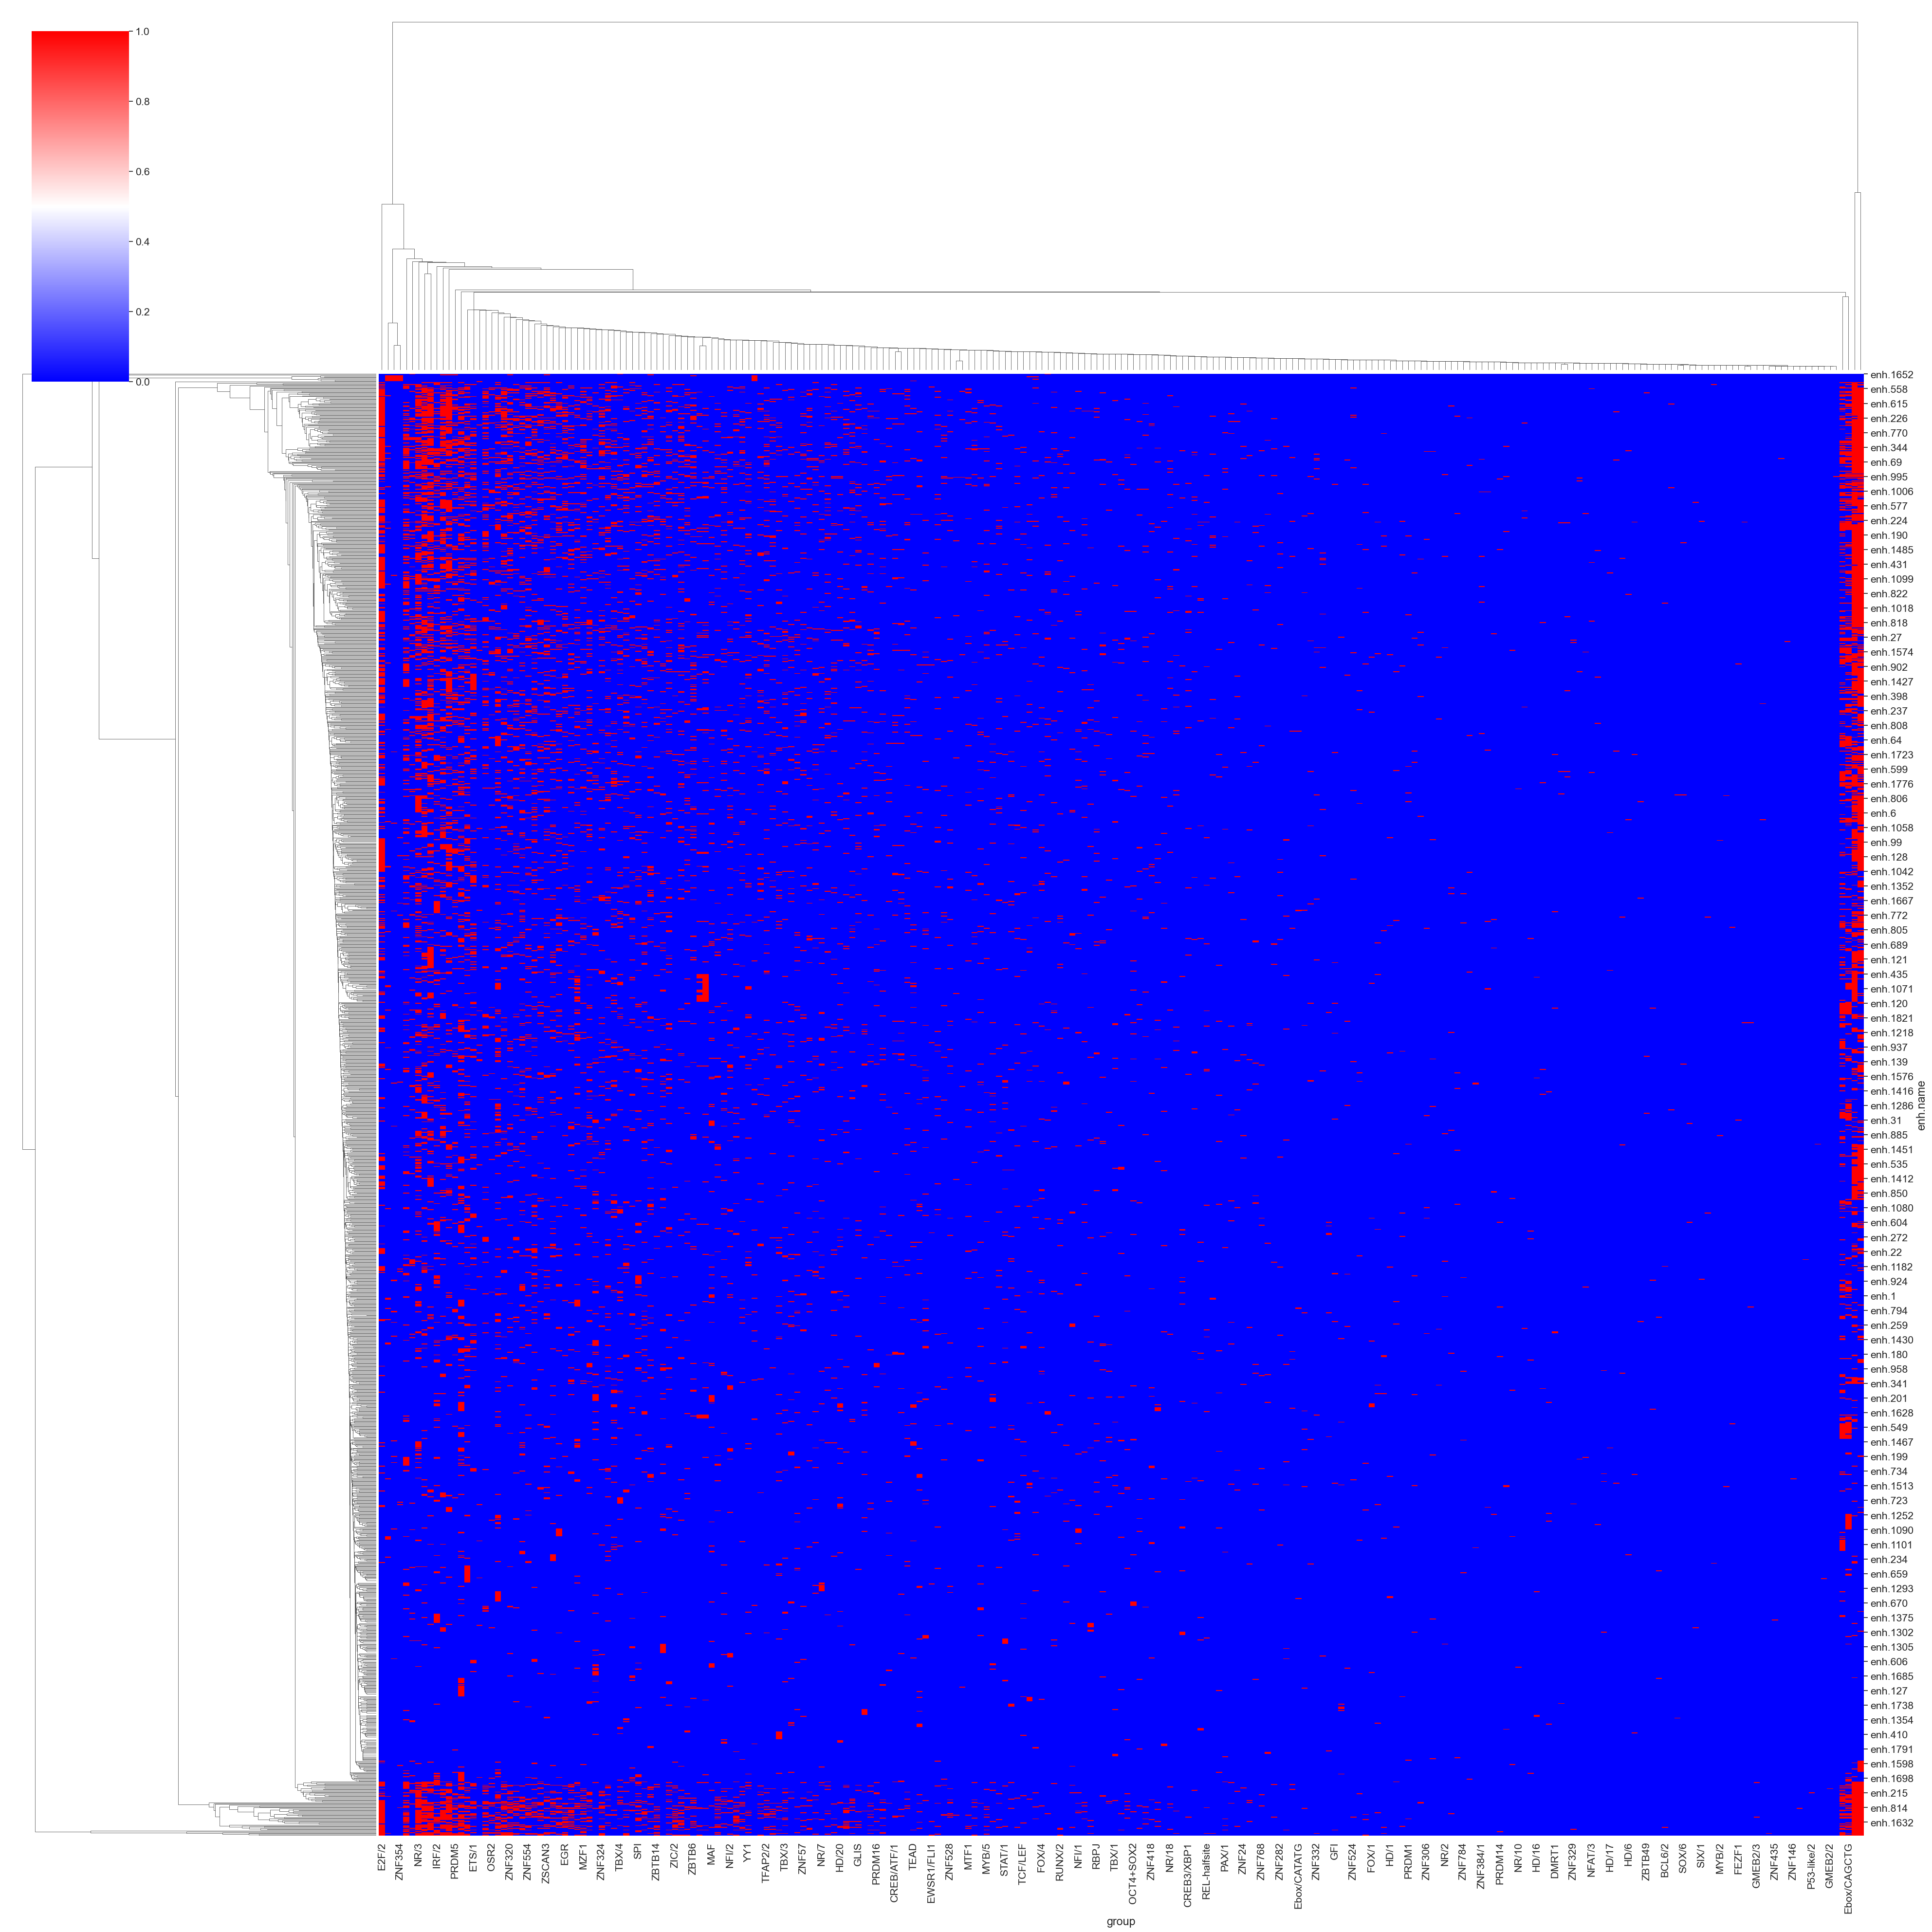

In [81]:
sns.set(font_scale=1.4)
sns.clustermap(table.fillna(0), robust=True, cmap="bwr", mask=table==0, figsize=(40,40))
